<img src=./logo.png><br>
* ref : https://www.kaggle.com/c/titanic

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings(action='ignore')


# Data Load

In [187]:
train = pd.read_csv("./dataset/train.csv")

In [188]:
print(train.shape)
print(train.info())
train.head()

(891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# EDA : 사전 데이터 탐색

## Survived : Traget Feature

In [189]:
train["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

## 레코드수 == 유니크수
* 대체로 분석 대상에서 제외(삭제)

* 간결 :  결측 or 유니크값

In [190]:
print(train.isna().sum()  [train.isna().sum() >0  ] )
print("---"*10)
print(train.nunique()     [train.nunique()  >= 650] )   #by 황지현

Age         177
Cabin       687
Embarked      2
dtype: int64
------------------------------
PassengerId    891
Name           891
Ticket         681
dtype: int64


In [191]:
def my_dfcheck(prm='null'):  #파라미터 : 'null' 또는 'unique'
    if prm == 'unique':
        s = train.nunique()
    else:
        s = train.isna().sum()
    
    rate = np.round( (s.values  / len(train)) *100,  1)
    dic = {"컬럼":s.index , "카운트":s.values, "비율":rate}
    df = pd.DataFrame(dic).sort_values('카운트', ascending=False)
    return df.T

# my_dfcheck ('null')
my_dfcheck('unique')

,0,3,8,9,10,5,6,7,2,11,1,4
컬럼,PassengerId,Name,Ticket,Fare,Cabin,Age,SibSp,Parch,Pclass,Embarked,Survived,Sex
카운트,891,891,681,248,147,88,7,7,3,3,2,2
비율,100.0,100.0,76.4,27.8,16.5,9.9,0.8,0.8,0.3,0.3,0.2,0.2


* Ticket이 생존과 관련이 있는지 확인 == '무의미함'으로 결론냄(삭제)

In [192]:
train[['Ticket', 'Survived']].value_counts().sort_values(ascending=False)
train[['Ticket', 'Embarked']].value_counts().sort_values(ascending=False)

Ticket            Embarked
CA. 2343          S           7
347082            S           7
1601              S           7
347088            S           6
3101295           S           6
                             ..
SOTON/O2 3101287  S           1
SW/PP 751         S           1
STON/O2. 3101283  S           1
STON/O2. 3101282  S           1
347466            S           1
Length: 682, dtype: int64

In [193]:
# train.head(2)   

# 피쳐 가공 (Feature Engineering & Preprocessing)

## 피쳐가공 : 결측 처리

* 11  Embarked    889 non-null    object  - 최빈도S
* 10  Cabin          204 non-null    object  - 공백처리, drop미정
*  5   Age            714 non-null    float64 - Name호칭별평균나이
				   -Ticket-Parch아이2

### Embarked  : 최빈도 채우기

In [194]:
mode_var = train['Embarked'].mode().values[0]
train['Embarked'] = train['Embarked'].fillna( mode_var )  # 'S'
print(train['Embarked'].isna().sum())

0


In [195]:
pd.crosstab(train['Embarked'], train['Survived'])

Survived,0,1
Embarked,,
C,75,93
Q,47,30
S,427,219


### Age : Name 호칭을 사용해 그들의 평균 나이로 채우기

* gropuby 값을 이용해 fillna()할 경우 transform() 사용
* train['Age'].apply()  train['Age'].transform()
* train.groupby("pclass")['Age'].apply() vs. train.groupby("pclass")['Age'].transform()
* https://steadiness-193.tistory.com/42

In [196]:
# avg_age = train['Age'].mean()
# train['Age'] = train['Age'].fillna(avg_age).astype('int')   #------df 컬럼 캐스팅

In [197]:
train['Name_title'] = train['Name'].str.extract(' ([A-Za-z]+)[.]', expand=False)
train[['Name_title', 'Name']].head()

,Name_title,Name
0,Mr,"Braund, Mr. Owen Harris"
1,Mrs,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,Miss,"Heikkinen, Miss. Laina"
3,Mrs,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,Mr,"Allen, Mr. William Henry"


In [198]:
#pd.crosstab(train["Name_title"], train['Age'])
train[["Name_title"]].value_counts()

Name_title
Mr            517
Miss          182
Mrs           125
Master         40
Dr              7
Rev             6
Major           2
Col             2
Mlle            2
Mme             1
Ms              1
Capt            1
Lady            1
Jonkheer        1
Don             1
Countess        1
Sir             1
dtype: int64

In [199]:
pd.crosstab(train["Name_title"],train["Age"].isna())

Age,False,True
Name_title,,
Capt,1,0
Col,2,0
Countess,1,0
Don,1,0
Dr,6,1
Jonkheer,1,0
Lady,1,0
Major,2,0
Master,36,4


* 중복 의미의 호칭 정리
<pre>
 Mme  Mlle  --> Mrs
 Ms   Lady  --> Miss

In [200]:
train["Name_title"].replace("Mme", "Mrs", inplace=True)
train["Name_title"].replace("Mlle", "Mrs", inplace=True)
train["Name_title"].replace("Ms", "Miss", inplace=True)
train["Name_title"].replace("Lady", "Miss", inplace=True)

In [201]:
train["Name_title"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Major', 'Sir',
       'Col', 'Capt', 'Countess', 'Jonkheer'], dtype=object)

In [202]:
train["Age"] = train["Age"].fillna(train.groupby(by="Name_title")["Age"].transform("mean"))

In [203]:
train['Age'].isna().sum()

0

In [204]:
train['Age'].head()

0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
Name: Age, dtype: float64

* 이름에서 꺼낸 호칭 인코딩(글자 --> 숫자)

In [205]:
pd.crosstab(train["Name_title"], train["Survived"])

title_dict = {'Major':0, 'Master':1,'Miss':2, 'Mr':3, 'Mrs':4, 'Rev':5,
              'Capt':6, 'Col':6, 'Countess':6, 'Don':6, 'Dr':6, 'Jonkheer':6, 'Sir':6 }
train["Name_title"] = train["Name_title"].map(title_dict)
train["Name_title"].value_counts()

3    517
2    184
4    128
1     40
6     14
5      6
0      2
Name: Name_title, dtype: int64

### Cabin : 공백처리
* 점수를 봐가며 삭제 여부 결정
* Pclass=1 인 승객 대부분이 Cabin을 가지고 있다
* 삭제여부 미정 : Pclass 하나만 봐도 된다
* A~T 세분화되어 있어서  C1 , C2 , C3

In [206]:
pd.unique(train['Cabin'])[:5]

array([nan, 'C85', 'C123', 'E46', 'G6'], dtype=object)

In [207]:
train['Cabin'] = train['Cabin'].str[0:1]

In [208]:
pd.crosstab(train['Cabin'], train['Pclass'] )

Pclass,1,2,3
Cabin,,,
A,15,0,0
B,47,0,0
C,59,0,0
D,29,4,0
E,25,4,3
F,0,8,5
G,0,0,4
T,1,0,0


In [209]:
pd.crosstab(train['Cabin'], train['Survived'] )

Survived,0,1
Cabin,,
A,8,7
B,12,35
C,24,35
D,8,25
E,8,24
F,5,8
G,2,2
T,1,0


In [210]:
train['Cabin'] = train['Cabin'].fillna('')

## 피쳐가공 : Object 타입 numeric(수치) 타입으로 변경
<pre>
10  Cabin          204 non-null    object  - ??
 4   Sex            891 non-null    object 
11  Embarked    889 non-null    object  - 최빈도S

* map
* replace
* lambda


* 옵션 : object 타입 컬럼만 뽑아오기

In [211]:
col_list = train.select_dtypes(include='object').columns.tolist()
print(col_list)

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


### df['col'].astype('category')

In [212]:
# train2 = train.copy()
train['Cabin'] = train['Cabin'].astype('category').cat.codes
train['Sex2'] = train['Sex'].astype('category').cat.codes
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_title,Sex2
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S,3,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,3,C,4,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,2,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,3,S,4,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S,3,1


### pd.get_dummies()
* 결측처리  + LabelEncoder() + OneHotEncoder()

In [213]:
train = pd.get_dummies(train, columns=['Sex'])
train.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_title,Sex2,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,0,S,3,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,3,C,4,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,0,S,2,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,3,S,4,0,1,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,0,S,3,1,0,1


### df.replace()
* df['col'].replace(['a','b'] , [1,2] , inplace=True)

In [214]:
train['Embarked'].replace(['S','C','Q'],[1,2,3], inplace=True)   #----------- inplace=True 추천
train['Embarked'].value_counts()


1    646
2    168
3     77
Name: Embarked, dtype: int64

### df.apply(lambda)

In [215]:
# train['Sex3'] = train['Sex'].apply(lambda x :  1 if x == 'male'  else 0) 
# train[['Sex3','Sex']].head()

In [216]:
## 피쳐 영향도 : 상관분석 
## PCA : 차원축소

## 스케일링 - 정규분포화(분류는 큰 영향이 없다)

## 정규표현식
## 바이닝(구간화)

## 평균&편차 -- 파생변수


In [217]:
train.head()   # 

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_title,Sex2,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,0,1,3,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,3,2,4,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,0,1,2,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,3,1,4,0,1,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,0,1,3,1,0,1


## 피쳐가공 :불필요한 컬럼 모두 삭제

* 삭제컬럼 : col_list = ['PassengerId', 'Name', 'Ticket']

In [218]:
col_list = ['PassengerId', 'Name', 'Ticket','Sex_female','Sex_male']
train = train.drop(col_list, axis=1)
train.head(2)   

,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Embarked,Name_title,Sex2
0,0,3,22.0,1,0,7.2500,0,1,3,1
1,1,1,38.0,1,0,71.2833,3,2,4,0


In [219]:
train = train.rename(columns={"Sex2":"Sex"})

In [220]:
train.head(2) 

,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Embarked,Name_title,Sex
0,0,3,22.0,1,0,7.2500,0,1,3,1
1,1,1,38.0,1,0,71.2833,3,2,4,0


## 상관분석 : 피쳐별 영향도 분석
* 피쳐간의 상관도(상관계수)가 높다 == 두 피쳐가 유사한 특징을 갖는다고 볼 수 있다.
* 다중공선성 : 두 피쳐가 상관계수가 높은 것 --> 일반적으로 모델의 학습이 떨어진다.

<pre>
±0.9이상             : 매우 높은 상관관계 → 다중공선성 문제
±0.7이상 ~ ±0.9미만  : 높은 상관관계
±0.4이상 ~ ±0.7미만  : 다소 높은 상관관계 → 0.7미만이면 다중공선성 안전
±0.2이상 ~ ±0.4미만  : 낮은 상관관계
±0.2미만             : 상관관계가 거의 없음
(상관관계계수의 최댓값은 1이고 최솟값은 -1입니다. 
 상관관계계수가 1이라는 것은 그 둘이 같다는 것입니다.)

In [221]:
#! pip install seaborn

In [222]:
import seaborn as sns

<AxesSubplot:>

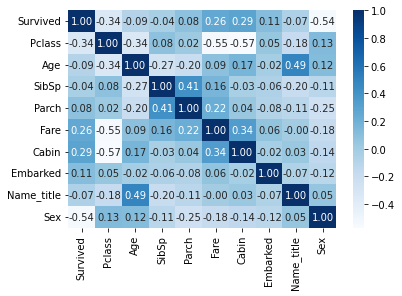

In [223]:
sns.heatmap(train.corr(), cmap='Blues' , annot=True, fmt=".2f")

### family = SibSp + Parch 파생변수
<pre>
1) train['family'] = SibSp(형제)  + Parch(부모자식) + 1

2) alone == family와 상관도가 높은 관계로 만들지 않기로 결정
   train['alone']  =  SibSp(형제)  + Parch(부모자식) ==> 혼자면1 아니면0
  
3) SibSp(형제)  + Parch(부모자식) drop



In [224]:
train['family'] = train['SibSp'] + train['Parch'] + 1
train[['SibSp','Parch','family']].head()

,SibSp,Parch,family
0,1,0,2
1,1,0,2
2,0,0,1
3,1,0,2
4,0,0,1


* 방법1) lambda 활용

In [225]:
# # -------- 컬럼 하나에만 람다 적용하는 경우
# # train['Age'] = train['Age'].apply(lambda x : 1 if x==20살 else 0) 

# # -------- 프레임 통째로 람다 적용하는 경우    , axis=1 추가
# train['alone'] = train.apply(lambda x : 1 if x['SibSp'] + x['Parch'] == 0 else 0, axis=1)
# train[['SibSp','Parch','family','alone']].head()

* 방법2) 컬럼+컬럼 연산

In [226]:
# train['alone']  =  train['SibSp'] + train['Parch'] == 0
# train['alone']  = train['alone'].astype('int')
# train[['SibSp','Parch','family','alone']].head()
# # train.info()

In [227]:
train = train.drop(['SibSp','Parch'], axis=1)
train.head()

,Survived,Pclass,Age,Fare,Cabin,Embarked,Name_title,Sex,family
0,0,3,22.0,7.2500,0,1,3,1,2
1,1,1,38.0,71.2833,3,2,4,0,2
2,1,3,26.0,7.9250,0,1,2,0,1
3,1,1,35.0,53.1000,3,1,4,0,2
4,0,3,35.0,8.0500,0,1,3,1,1


# 모델학습 & 평가

<pre><b>
지도학습   :   Supervised learning   : 분류(classsification), 회귀(regression)
비지도학습 : Unsupervised learning   : 군집(clustering)


## 문제지 답안지 분리

In [228]:
y = train['Survived']
X = train.drop(['Survived'], axis=1)
# print(y[:3])
# print(X.head())

In [229]:
X_train,X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2, 
                                                   random_state=1234,
                                                   shuffle=True
                                                   )
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(712, 8) (179, 8) (712,) (179,)


## 모델 선정 & 학습 & 예측 & 평가

In [230]:
model_list = [RandomForestClassifier(n_estimators=300, random_state=1234) ,
              LogisticRegression(penalty="l2", random_state=1234),
              KNeighborsClassifier(),
              DecisionTreeClassifier(),
              LinearSVC()
             ]
# model = RandomForestClassifier()
for model in model_list:
    model.fit(X_train, y_train)  #---학습해라
    내답안지 = model.predict(X_test)
    acc_score = accuracy_score(y_test, 내답안지)
    print(f"{model.__class__.__name__} \t\t 정확도:{acc_score:.4f}")


RandomForestClassifier 		 정확도:0.8324
LogisticRegression 		 정확도:0.8380
KNeighborsClassifier 		 정확도:0.7207
DecisionTreeClassifier 		 정확도:0.8045
LinearSVC 		 정확도:0.6201


<pre>
RandomForestClassifier정확도 : 0.810056
LogisticRegression정확도 : 0.821229
KNeighborsClassifier정확도 : 0.709497
DecisionTreeClassifier정확도 : 0.793296
LinearSVC정확도 : 0.759777
-----------------------------------------------평균나이 , Name_title
RandomForestClassifier 		 정확도:0.8268
LogisticRegression 		 정확도:0.8492
KNeighborsClassifier 		 정확도:0.7263
DecisionTreeClassifier 		 정확도:0.7989
LinearSVC 		 정확도:0.7430
----------------------------------------------- alone family 파생변수 추가
RandomForestClassifier 		 정확도:0.8268
LogisticRegression 		 정확도:0.8324
KNeighborsClassifier 		 정확도:0.7263
DecisionTreeClassifier 		 정확도:0.7933
LinearSVC 		 정확도:0.8101
RandomForestClassifier정확도 : 0.81005
----------------------------------------------- family 파생변수 추가
RandomForestClassifier 		 정확도:0.8324
LogisticRegression 		 정확도:0.8380
KNeighborsClassifier 		 정확도:0.7207
DecisionTreeClassifier 		 정확도:0.8045
LinearSVC 		 정확도:0.6201


# 모델튜닝 & 검증


In [231]:
## 검증 + 통계

In [232]:
## 가공, 모델, 데이터 증강
## 모델튜닝 ... 도구